<a href="https://colab.research.google.com/github/e-olang/Computer-Vision/blob/main/Brain%20Cancer%20Detection/train_draft2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Sort Files and Split

In [ ]:
#data_root_dir = '/content/drive/MyDrive/Colab Notebooks/data/Multi Cancer/Brain Cancer'
train_dir = '/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/test'
val_dir = '/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/val'

In [ ]:
! pip install split-folders -q

In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/Colab Notebooks/data/Multi Cancer/Brain Cancer', output = '/content/drive/MyDrive/Colab Notebooks/Cancer/train', seed = 42, ratio = (.7, .2, .1), group_prefix =None, move = False )

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib

train_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/train')
test_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/test')
val_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/val')

In [3]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
print(str(train_image_count) + ' Training Images')

test_image_count = len(list(test_dir.glob('*/*.jpg')))
print(str(test_image_count) + ' Testing Images')

val_image_count = len(list(val_dir.glob('*/*.jpg')))
print(str(val_image_count) + ' Validation Images')

10500 Training Images
1500 Testing Images
3000 Validation Images


--------------------------------------------

In [4]:
data_dir = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/data/Multi Cancer/Brain Cancer')

In [5]:
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10500 files belonging to 3 classes.
Using 9450 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 10500 files belonging to 3 classes.
Using 1050 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['brain_glioma', 'brain_menin', 'brain_tumor']


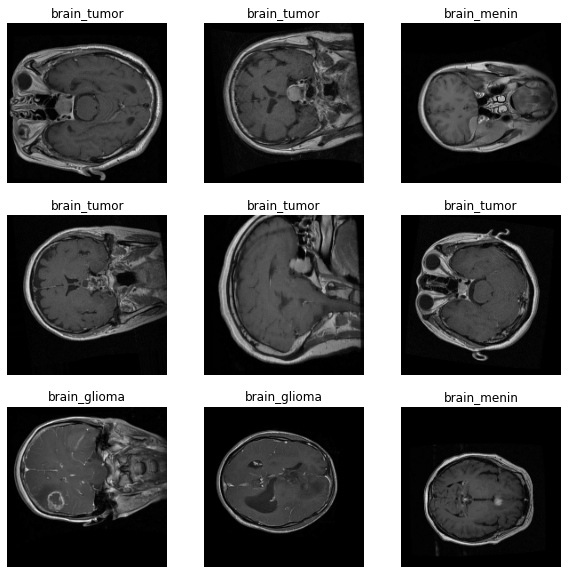

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97205395


In [14]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [17]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
296/296 [==============================] - 82s 240ms/step - loss: 0.6296 - accuracy: 0.7212 - val_loss: 0.5247 - val_accuracy: 0.7733
Epoch 2/10
296/296 [==============================] - 7s 22ms/step - loss: 0.4395 - accuracy: 0.8262 - val_loss: 0.4115 - val_accuracy: 0.8248
Epoch 3/10
296/296 [==============================] - 7s 23ms/step - loss: 0.3247 - accuracy: 0.8692 - val_loss: 0.3352 - val_accuracy: 0.8667
Epoch 4/10
296/296 [==============================] - 7s 22ms/step - loss: 0.2229 - accuracy: 0.9109 - val_loss: 0.2981 - val_accuracy: 0.8810
Epoch 5/10
296/296 [==============================] - 6s 22ms/step - loss: 0.1442 - accuracy: 0.9469 - val_loss: 0.2799 - val_accuracy: 0.8895
Epoch 6/10
296/296 [==============================] - 7s 22ms/step - loss: 0.0915 - accuracy: 0.9659 - val_loss: 0.2633 - val_accuracy: 0.9152
Epoch 7/10
296/296 [==============================] - 7s 22ms/step - loss: 0.0545 - accuracy: 0.9808 - val_loss: 0.3566 - val_accuracy: 0.88

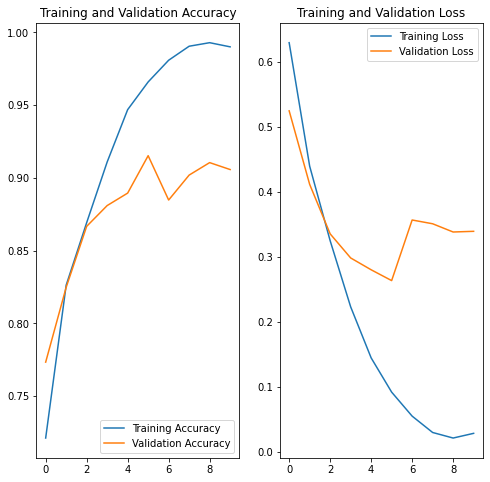

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

------

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

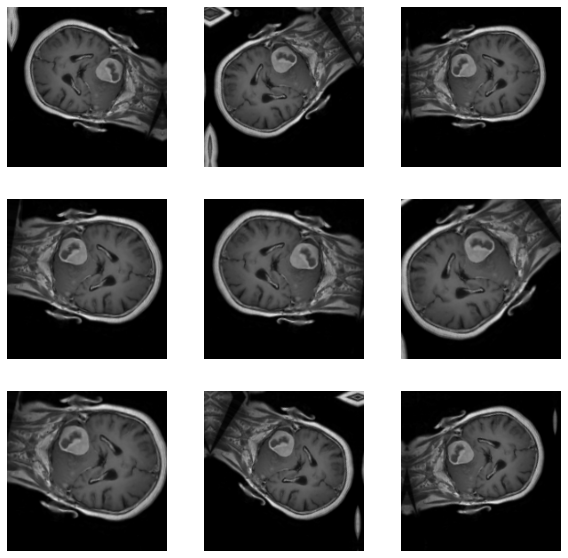

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [21]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [22]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [25]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
296/296 [==============================] - 8s 25ms/step - loss: 0.7185 - accuracy: 0.6761 - val_loss: 0.5251 - val_accuracy: 0.7829
Epoch 2/15
296/296 [==============================] - 7s 25ms/step - loss: 0.5747 - accuracy: 0.7605 - val_loss: 0.4800 - val_accuracy: 0.8048
Epoch 3/15
296/296 [==============================] - 7s 25ms/step - loss: 0.5207 - accuracy: 0.7875 - val_loss: 0.4486 - val_accuracy: 0.8210
Epoch 4/15
296/296 [==============================] - 7s 25ms/step - loss: 0.4824 - accuracy: 0.8060 - val_loss: 0.4295 - val_accuracy: 0.8286
Epoch 5/15
296/296 [==============================] - 7s 25ms/step - loss: 0.4342 - accuracy: 0.8273 - val_loss: 0.3617 - val_accuracy: 0.8562
Epoch 6/15
296/296 [==============================] - 8s 25ms/step - loss: 0.4022 - accuracy: 0.8354 - val_loss: 0.3287 - val_accuracy: 0.8619
Epoch 7/15
296/296 [==============================] - 7s 24ms/step - loss: 0.3748 - accuracy: 0.8545 - val_loss: 0.3199 - val_accuracy: 0.8724

In [27]:
img_path = '/content/drive/MyDrive/Colab Notebooks/Cancer/brain cancer/test/brain_menin/brain_menin_4927.jpg'

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(
    np.max(score)
)

This image most likely belongs to brain_menin with a 74.85 percent confidence.
0.7484834
